In [15]:
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

import scipy.sparse


3.9.3


In [18]:
sleep = pd.read_csv('/home/mach1ne/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


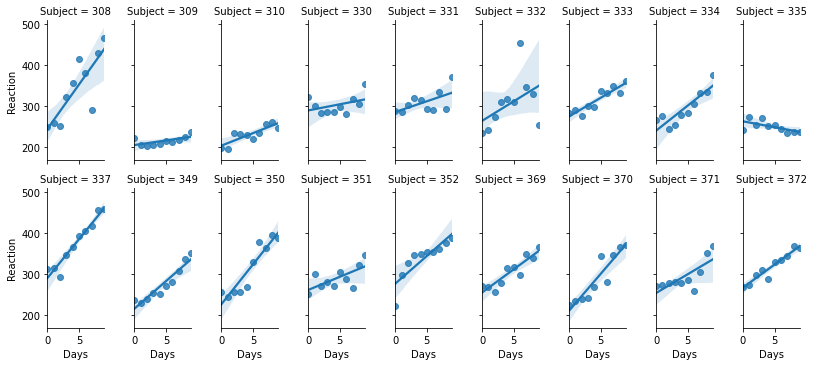

In [19]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.5, size=2.5);

# Random effect on the intercepts and slopes

Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [25]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X.shape

(180, 2)

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [39]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)


print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [41]:
Y = np.asarray(sleep['Reaction'])
n_random_effects = X.shape[1]
n_subjects = Z_intercept.shape[1]

In [48]:
with pm.Model() as model:

    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=1000) # contrain it to positive values
    beta_X_slope = pm.StudentT('beta_X_slope', mu=0, sd=100, nu=3)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
        
    ## Random effect
    # Prior on the standard deviation of the random effects
    sigma_Z = pm.HalfNormal.dist(sd=100, shape=n_random_effects)
    
    # Build the covariance matrix
    chol_packed = pm.LKJCholeskyCov('chol_packed', n=n_random_effects, eta=1, sd_dist=sigma_Z)
    chol = pm.expand_packed_triangular(n_random_effects, chol_packed, lower=True)
    
    covariance_matrix = pm.Deterministic('covariance_matrix', tt.dot(chol, chol.T))
    
    # Extract the standard deviations and rho
    standard_deviations = pm.Deterministic('standard_deviations', tt.sqrt(tt.diag(covariance_matrix)))
    correlation_matrix = pm.Deterministic('correlation_matrix', tt.diag(standard_deviations**-1).dot(covariance_matrix.dot(tt.diag(standard_deviations**-1))))
    rho = pm.Deterministic('rho', correlation_matrix[np.triu_indices(2, k=1)])
       
    # Centered parametrization
    #gamma_Z = pm.MvNormal('gamma_Z', mu=np.zeros(n_random_effects), chol=chol, shape=(n_subjects, n_random_effects))
    #tt.printing.Print('gamma_Z')(gamma_Z.shape)
    
    ## Alternative Non centered
    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=(n_subjects, n_random_effects))
    gamma_Z = pm.Deterministic('gamma_Z', tt.dot(chol, gamma_Z_raw.T).T)
    
    # Separate the coefficients for intercept and slope
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z[:, 0])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z[:, 1])
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 

    ## likelihood
    mu_estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, chol_packed, beta_X_slope, beta_X_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


In [58]:
pm.summary(trace, varnames=['beta_X_intercept', 'beta_X_slope', 'rho', 'standard_deviations']).round(2)

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_X_intercept,251.32,7.72,236.25,265.94,0.18,0.12,1945.0,1945.0,1999.0,2046.0,1.0
beta_X_slope,10.48,1.74,7.20,13.76,0.04,0.03,1687.0,1687.0,1711.0,2058.0,1.0
rho[0],0.08,0.30,-0.46,0.61,0.01,0.01,1220.0,1220.0,1205.0,1658.0,1.0
standard_deviations[0],27.25,6.79,14.97,39.51,0.16,0.12,1709.0,1709.0,1689.0,1728.0,1.0
standard_deviations[1],6.60,1.53,3.92,9.33,0.04,0.03,1655.0,1573.0,1801.0,1781.0,1.0


In [51]:
covariance_matrix = np.mean(trace['covariance_matrix'], 0)
covariance_matrix

array([[788.43939506,   7.65802688],
       [  7.65802688,  45.91896107]])

In [52]:
standard_deviations = np.mean(trace['standard_deviations'], 0)
standard_deviations

array([27.24641329,  6.6017317 ])

In [53]:
correlation_matrix = np.mean(trace['correlation_matrix'], 0)
correlation_matrix

array([[1.        , 0.07459053],
       [0.07459053, 1.        ]])

In [54]:
rho = np.mean(trace['rho'], 0)
rho

array([0.07459053])

In [60]:
trace_df = pm.trace_to_dataframe(trace)
yvars = [col for col in trace_df.columns if 'gamma_Z_slope' in col and 'raw' not in col]
xvars = [col for col in trace_df.columns if 'gamma_Z_intercept' in col and 'raw' not in col]

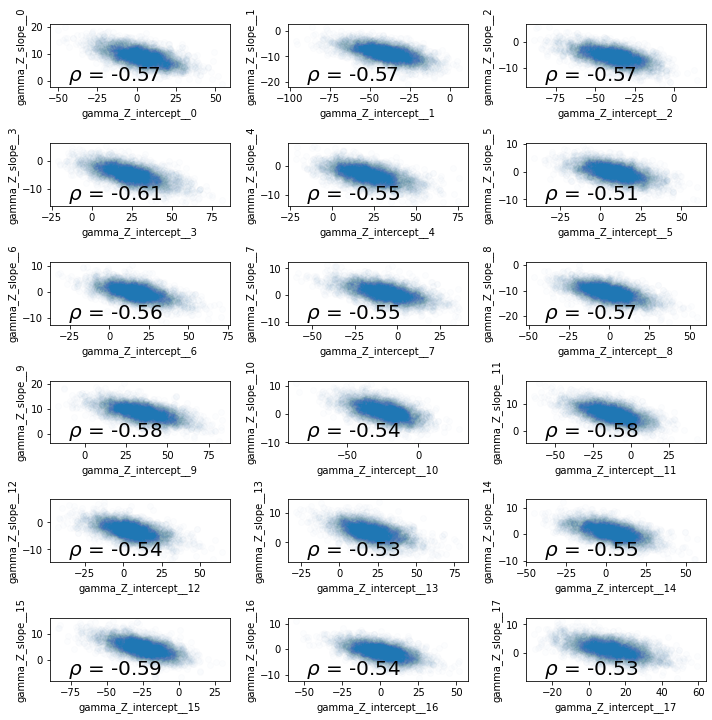

In [61]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(10, 10))
for i, axi in enumerate(ax.ravel()):
    axi.plot(trace_df[xvars[i]], trace_df[yvars[i]], 'o', alpha=0.01)
    axi.set_xlabel(xvars[i])
    axi.set_ylabel(yvars[i])
    axi.text(0.1, 0.1, '$\\rho$ = {}'.format(np.round(np.corrcoef(trace_df[xvars[i]], trace_df[yvars[i]])[0, 1], 2)),
             fontsize=20, transform=axi.transAxes)
    
plt.tight_layout()

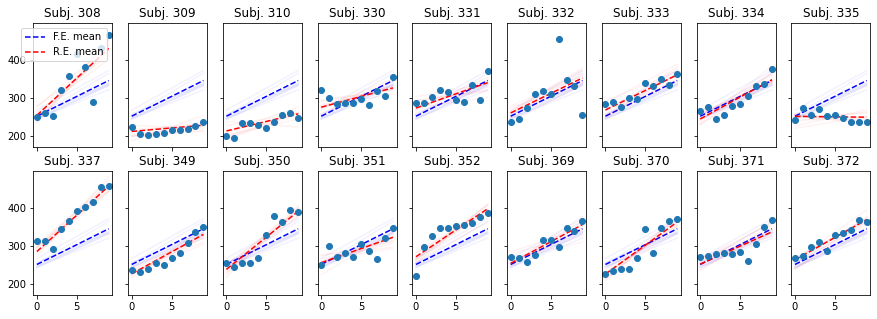

In [63]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g0, g1 in zip(trace_df['beta_X_intercept'][::500], 
                              trace_df['beta_X_slope'][::500],
                              trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                              trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, (b0 + g0) + days * (b1 + g1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

In [65]:
ppc = pm.sample_posterior_predictive(trace, samples=250, model=model)

/home/mach1ne/anaconda3/envs/bayesian_analysis_with_python/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


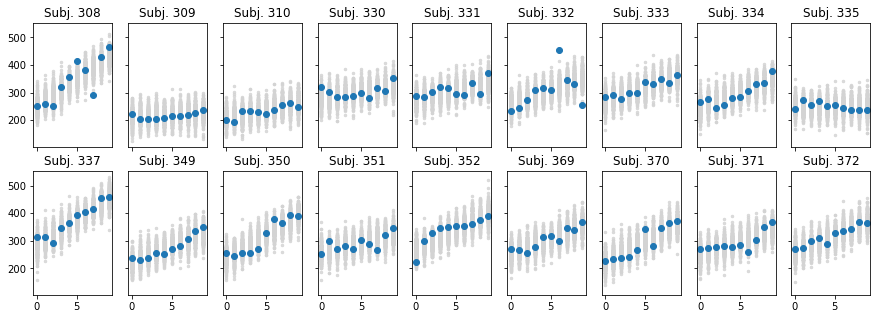

In [66]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))